# Modeling and Evaluation

**Objective**: This notebook covers the second phase of my sales forecasting project. The goal is to build, train and evaluate a time-series model to predict sales for a stingle store-item combination. I will first establish a naive baseline to measure against, then implement a predictive model using the Prophet library, and finally, evaluate its performance and visualize the forecast.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pmdarima as pm
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

# Load the data and convert the 'date' column to a format Python can understand
df = pd.read_csv('../data/train.csv', parse_dates=['date'])

# Ignoring all 'FutureWarning'
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Preprocessing

To make the problem easier to start with, I will focus on forecasting just for a single store and a single item. Afterwards i will apply the solution to the full dataset. As such, I start by filtering the data to only include sales for Store 1, Item 1.

In [3]:
# Isolate a single time series to simplify the problem
# Starting with just Store 1, Item 1
df_s1_i1 = df[(df['store'] == 1) & (df['item'] == 1)].copy()

I am going to use a forecasting library called Prophet. This library has some specific rules: The date column must be named 'ds'; and the value we want to forecast must be names 'y'. Therefore the next step is to create a new DataFrame with just these two columns with correctly names colums.

In [4]:
# Prepare the data for Prophet
# Prophet requires the columns to be named 'ds' for date and 'y' for the value to forecast
df_prophet = df_s1_i1[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

print("Data prepared for Prophet:")
df_prophet.head()

Data prepared for Prophet:


,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


### Establish a Baseline Forecast

Before getting fancy, I need to set a benchmark to measure performance against. For this i will create a very simple "naive forecast". From the EDA we know that there is a strong weekly pattern. So, the naive forecast will be *"The sales for any given day will be the same as the sales on that same day last week."* To achieve this forecast we simply shift the sales data forward by seven days and remove the first seven empty values caused by the shift.


In [5]:
# Shifting the sales data by seven days to create the naive forecast
df_prophet['naive_forecast'] = df_prophet['y'].shift(7)

# Removing the first seven days because there is no data
df_prophet.dropna(inplace=True)

# Calculate the error of the naive forecast
# The Mean Absolute Error (MAE) tells us, on average, how wrong the forecast is
# For this data, an MAE of 3 means the forecast is off by an average of 3 units per day

mae_baseline = mean_absolute_error(df_prophet['y'], df_prophet['naive_forecast'])

print(f"The baseline MAE to beat is: {mae_baseline:.2f}")

The baseline MAE to beat is: 4.90


### Implement and Train the Prophet Model

To test the model's performance, I need to split the data. I'll use the majority of the data for training and reserve the last 90 days as a validation set. The model will train on the past and then try to predict the most recent 90-day period.

In [6]:
# Creating the training set
train = df_prophet[:-90]

# Create the validation set
validation = df_prophet[-90:]

Now, creating the Prophet model. Using the 'fit' method where the model learns all the underlying patterns present in the training data.

In [7]:
# Initializing the Prophet model
m = Prophet()

# Fit the model to the training data
m.fit(train)

22:30:39 - cmdstanpy - INFO - Chain [1] start processing
22:30:39 - cmdstanpy - INFO - Chain [1] done processing


With the model trained, it's now possible to make forecasts. For this I will create a DataFrame containing the future 90 days from the training period and ask the model to predict the sales for those dates, matching the validation period.

In [8]:
# Create a DataFrame that extends 90 days from into the future from the training period
future = m.make_future_dataframe(periods=90)

# Use the trained model to make a forecast
forecast = m.predict(future)

# 'yhat' is the model's prediction
# 'yhat_lower' and 'yhat_upper' represents the best and worst case
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1814,2017-12-27,16.287655,10.479088,21.755103
1815,2017-12-28,16.925322,11.028890,22.478813
1816,2017-12-29,18.744908,13.501904,24.795614
1817,2017-12-30,20.570715,14.692534,26.086543
1818,2017-12-31,21.421936,16.181605,27.027926


### Visualizing Model Performance

Now we'll compare the model's predictions to the actual sales figures from our validation set to see how well it performed. The goal is to get a Mean Absolute Error (MAE) that is lower than our baseline MAE of 4.90.

Now, on to the comparison. The goal is to get a Mean Absolute Error that is lower than the baseline MAE of 4.90.

In [9]:

# The forecast dataframe contains predictions for the entire history
# To validate, I only need the predictions for 90-day validation period

forecast_validation = forecast[-90:]

# Calculate the MAE for the Prophet model's forecast

mae_prophet = mean_absolute_error(validation['y'], forecast_validation['yhat'])

print(f"The baseline MAE was: {mae_baseline:.2f}")
print(f"The Prophet model's MAE is: {mae_prophet:.2f}")

The baseline MAE was: 4.90
The Prophet model's MAE is: 3.77


**Results**:

- Baseline MAE: 4.90
- Model MAE: 3.77

**Conclusion**:

The model, with a MAE of 3.77, outperforms the naive baseline. This confirms that the model has learned the underlying patterns in the data and providing a more accurate forecast then a simple "same day last week" guess. On average, the model's daily forecast is off by only 3.77 unites.


For evaluation it is generally easier to visually inspect the forecast. The following plot will show the actual sales data (black dots), the model's prediction (blue line), and the model's uncertainty interval (the light blue shaded areas)

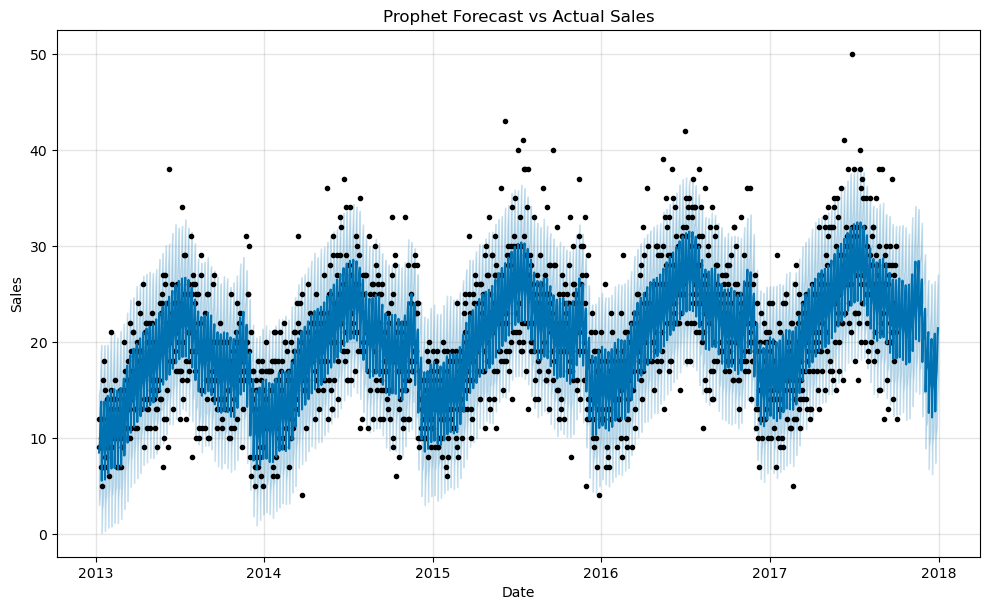

In [10]:
# Use built-ins from the Prophet library to visualize the forecast
fig1 = m.plot(forecast)
plt.title('Prophet Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### Visual Forecast Analysis

The above plot visualizes the model's performance over the entire dataset.

**Key Observations**:
- The blue forecast line tracks actual sales very well
- The model has identified the long-term upward trend in sales
- The light-blue uncertainty gets slightly wider during the summer peak, correctly modeling the increased sales volatility observed during the EDA.

Finally, I will utilize Prophet's ability to show what it has learned by plotting the components of the forecast to see the patterns it learned from the data. This should look similar to the patterns identified during the EDA.

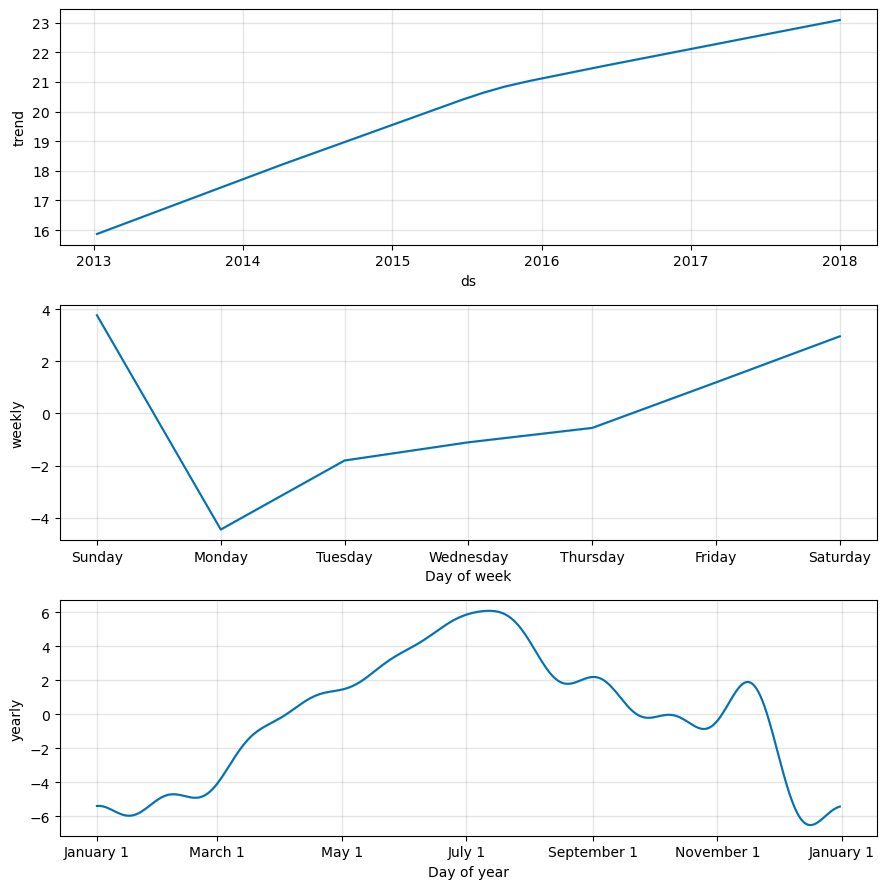

In [11]:
# Plot the individual components of the forecast
fig2 = m.plot_components(forecast)
plt.show()

### Forecast Component Analysis

These plots shows exactly what patterns the model learned.

**Conclusion:** The model has successfully identified the same three key patterns discovered manually in the EDA:

1.  **Trend:** A steady, growth over the five-year period.
2.  **Weekly Seasonality:** Sales are lowest on Monday and peak on Sunday.
3.  **Yearly Seasonality:** Sales are highest in the summer and lowest during the winter.

This confirms that the model is working as expected and its internal logic aligns with the analysis.

---
# Model Refinement with SARIMA

To see if we can improve upon our Prophet model, we will now implement a classic statistical forecasting model: **SARIMA** (Seasonal Auto-Regressive Integrated Moving Average).

The first and most critical step is to find the optimal parameters for the model. We will use the `auto_arima` function from the `pmdarima` library to automate this search process. This function will test many different model configurations and select the best one based on a statistical criterion (AIC).

In [12]:
sarima_model = pm.auto_arima(train['y'],
                             m=7, # Weekly cycle
                             trace=True, # Print the results of each model tries
                             error_action='ignore', # Ignores combinations of parameters that cause error during model fitting
                             suppress_warnings=True, # Prevents warnings that cause clutter
                             stepwise=True) # Enables the use of a more efficient algorithm to find the best model parameters


print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11673.159, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11181.530, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10636.751, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11671.159, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10742.165, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10565.141, Time=0.56 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=11522.101, Time=0.26 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10558.542, Time=0.72 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10630.194, Time=0.34 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=11156.9

### Make and Evaluate SARIMA Forecast

With the tuned SARIMA model, its now possible to forecast the next 90 days again and compare the performance against previous models

In [18]:
# Use the trained SARIMA model to predict the next 90 days
sarima_forecast = sarima_model.predict(n_periods=len(validation))

# Convert the result into a pandas Series with the correct dates for easy plotting and evaluation
sarima_forecast = pd.Series(sarima_forecast, name='sarima_forecast', index=validation.index)

/Users/emilmidtlyng/miniforge3/envs/sales_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [14]:
# Check for any missing values
print("Number of missing values in the SARIMA Forecast:")
print(sarima_forecast.isnull().sum())

print("\nLast 10 valuesof the SARIMA Forecast:")
print(sarima_forecast.tail(10))

Number of missing values in the SARIMA Forecast:
7

Last 10 valuesof the SARIMA Forecast:
1816    24.096661
1817    26.116271
1818    24.257532
1819          NaN
1820          NaN
1821          NaN
1822          NaN
1823          NaN
1824          NaN
1825          NaN
Name: sarima_forecast, dtype: float64


In [15]:
# Combining the Actual Sales data and the SARIMA Forecast into a single DataFrame for evaluation
evaluation_df = pd.DataFrame({
    'actual_sales': validation['y'],
    'sarima_forecast': sarima_forecast
})

# Drop any rows where either set has a missing value, since these will break the calculation of Mean Absolute Error
evaluation_df.dropna(inplace=True)

# Calculating the MAE
mae_sarima = mean_absolute_error(evaluation_df['actual_sales'], evaluation_df['sarima_forecast'])

print(f"The baseline MAE was: {mae_baseline:.2f}")
print(f"The Prophet model's MAE is: {mae_prophet:.2f}")
print(f"The SARIMA model's MAE is: {mae_sarima:.2f}")

The baseline MAE was: 4.90
The Prophet model's MAE is: 3.77
The SARIMA model's MAE is: 4.79


Plotting the SARIMA forecast against the actual sales data for the 90-day validation period to conduct a visual inspection.

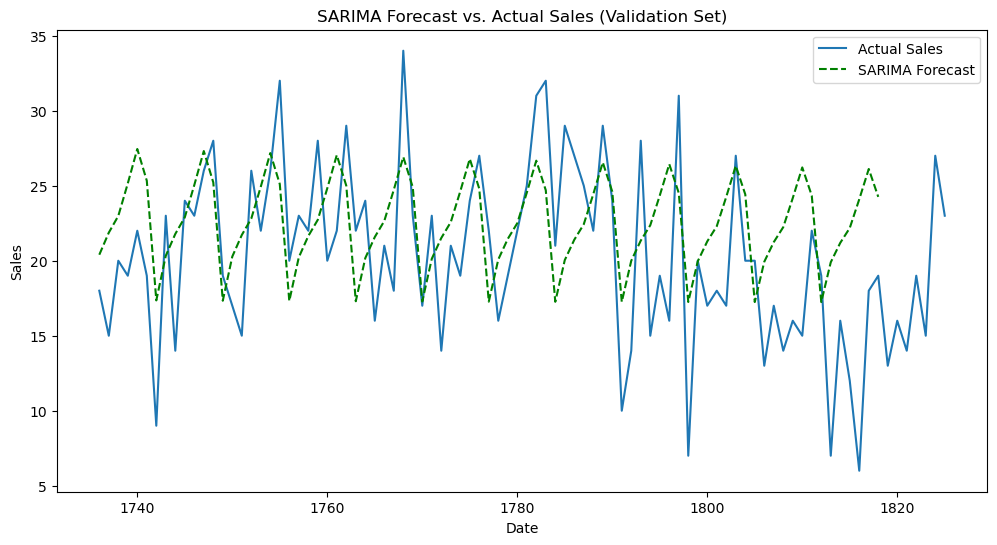

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(validation.index, validation['y'], label='Actual Sales')
plt.plot(validation.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('SARIMA Forecast vs. Actual Sales (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Conclusion and Next Steps

This project successfully achieved its primary goal of completing an end-to-end time-series forecasting analysis. From initial setup and exploratory data analysis to building, evaluating, and comparing two distinct models, the workflow provided valuable, hands-on experience with industry-standard tools and best practices.

***

## Final Model Comparison

The performance of the predictive models was evaluated against the naive seasonal baseline using **Mean Absolute Error (MAE)** on the 90-day validation set. The Prophet model demonstrated significantly better performance.

| Model                     | Mean Absolute Error (MAE) |
| ------------------------- | ------------------------- |
| **Prophet** | **3.77** |
| SARIMA (4,1,1)(1,0,1)[7] | 4.79                      |
| Naive Seasonal Baseline   | 4.90                      |

***

## Key Findings

-   **Prophet is the Superior Model:** For this dataset, the **Prophet model was the clear winner**. It was not only more accurate but also easier to implement, as it automatically detected the trend and seasonalities discovered during the EDA phase.

-   **Value of Classical Models:** The **SARIMA model**, while not as accurate as Prophet, still provided a valuable forecast that successfully outperformed the naive baseline, demonstrating the power of classical statistical methods.

-   **Metric Selection:** **MAE** was used as the primary evaluation metric because its direct interpretation (e.g., "the forecast is off by an average of 3.77 units") is more intuitive for communicating business impact than the competition's SMAPE metric.

***

## Next Steps

The next logical step is to scale this analysis from a single time series to a full competition entry. This involves:

1.  **Automate the Forecasting Pipeline:** Write a script that loops through all 500 unique store-item combinations.
2.  **Generate Predictions:** For each combination, train the superior Prophet model and generate a 90-day sales forecast.
3.  **Create Submission File:** Combine all forecasts into a single `submission.csv` file in the format required by the Kaggle competition.

## Improving Prophet with Holidays

In [ ]:
# Initialize new Prophet model
model_with_holidays = Prophet()

# Add US holidays, matching the origin country of the sales data
model_with_holidays.add_country_holidays(country_name='US')

# Fit the model to the same training data as previously
model_with_holidays.fit(train)

07:32:09 - cmdstanpy - INFO - Chain [1] start processing
07:32:09 - cmdstanpy - INFO - Chain [1] done processing


--- Model Performance Comparison ---
Original Prophet MAE: 3.77
New Prophet MAE with Holidays: 3.72


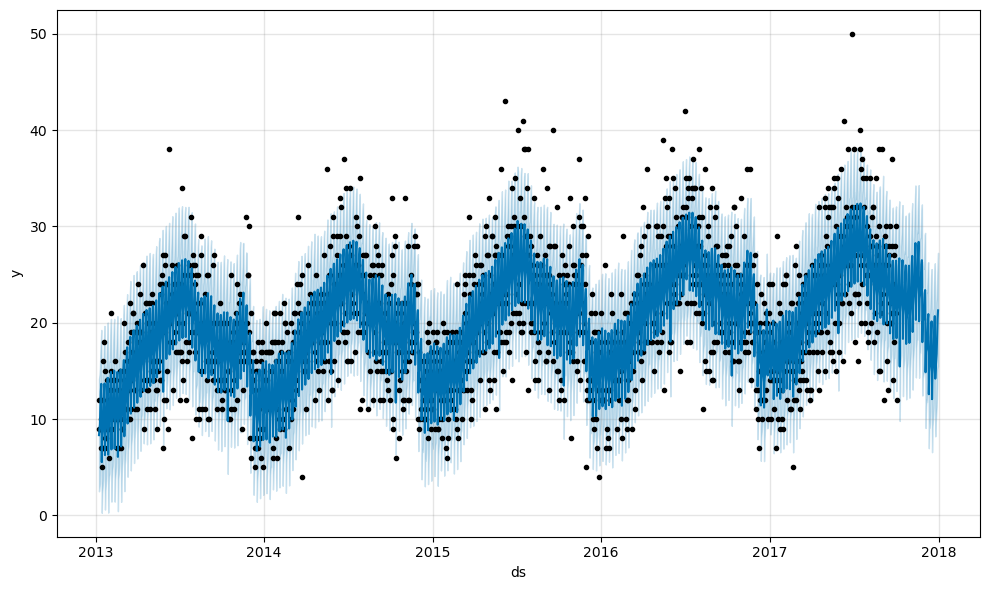

In [20]:
# Creating a new future DataFrame for the 90-day validation period
future_holidays = model_with_holidays.make_future_dataframe(periods=90)

# Generating the forecast using the new model
forecast_holidays = model_with_holidays.predict(future_holidays)

# --- Evaluation ---

# Isolate the predicted values for the validation period
y_pred_holidays = forecast_holidays['yhat'][-90:]

# Isolate the actual values from the validation set
y_true = validation['y']

# Calculate the Mean Absolute Error
mae_holidays = mean_absolute_error(y_true, y_pred_holidays)

print("--- Model Performance Comparison ---")
print(f"Original Prophet MAE: {mae_prophet:.2f}")
print(f"New Prophet MAE with Holidays: {mae_holidays:.2f}")

# Visualize the new forecast
fig3 = model_with_holidays.plot(forecast_holidays)
plt.show()

## Adjusting Hyperparameters

From EDA: Talking points to come.

Doing a grid search:

In [21]:
# Defining values to test
changepoint_priors = [0.01, 0.05, 0.1, 0.5]
seasonality_priors = [1.0, 5.0, 10.0]

results = []

print("Starting grid search...")

# Loop through all combinations
for cp in changepoint_priors:
    for sp in seasonality_priors:
        # Configure and train the model
        model = Prophet(
            changepoint_prior_scale=cp,
            seasonality_prior_scale=sp
        )
        model.add_country_holidays(country_name='US')
        model.fit(train)

        # Make forecast and calculate MAE
        future = model.make_future_dataframe(periods=90)
        forecast = model.predict(future)
        y_pred = forecast['yhat'][-90:]
        y_true = validation['y']
        mae = mean_absolute_error(y_true, y_pred)

        results.append({'changepoint_prior': cp, 'seasonality_prior': sp, 'mae': mae})
        print(f"    Tested cp={cp}, sp={sp} -> MAE: {mae:.3f}")

# Find the best combination of parameters
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['mae'].idxmin()]

print("\n--- Grid Search Complete ---")
print("Best parameters found:")
print(best_params)

08:11:07 - cmdstanpy - INFO - Chain [1] start processing
08:11:07 - cmdstanpy - INFO - Chain [1] done processing


Starting grid search...


08:11:07 - cmdstanpy - INFO - Chain [1] start processing


    Tested cp=0.01, sp=1.0 -> MAE: 3.867


08:11:08 - cmdstanpy - INFO - Chain [1] done processing
08:11:08 - cmdstanpy - INFO - Chain [1] start processing


    Tested cp=0.01, sp=5.0 -> MAE: 3.829


08:11:08 - cmdstanpy - INFO - Chain [1] done processing
08:11:08 - cmdstanpy - INFO - Chain [1] start processing
08:11:08 - cmdstanpy - INFO - Chain [1] done processing


    Tested cp=0.01, sp=10.0 -> MAE: 3.828


08:11:09 - cmdstanpy - INFO - Chain [1] start processing
08:11:09 - cmdstanpy - INFO - Chain [1] done processing


    Tested cp=0.05, sp=1.0 -> MAE: 3.726


08:11:09 - cmdstanpy - INFO - Chain [1] start processing
08:11:09 - cmdstanpy - INFO - Chain [1] done processing


    Tested cp=0.05, sp=5.0 -> MAE: 3.721


08:11:09 - cmdstanpy - INFO - Chain [1] start processing
08:11:09 - cmdstanpy - INFO - Chain [1] done processing


    Tested cp=0.05, sp=10.0 -> MAE: 3.719


08:11:10 - cmdstanpy - INFO - Chain [1] start processing
08:11:10 - cmdstanpy - INFO - Chain [1] done processing


    Tested cp=0.1, sp=1.0 -> MAE: 3.704


08:11:10 - cmdstanpy - INFO - Chain [1] start processing
08:11:10 - cmdstanpy - INFO - Chain [1] done processing


    Tested cp=0.1, sp=5.0 -> MAE: 3.704


08:11:10 - cmdstanpy - INFO - Chain [1] start processing


    Tested cp=0.1, sp=10.0 -> MAE: 3.707


08:11:10 - cmdstanpy - INFO - Chain [1] done processing
08:11:11 - cmdstanpy - INFO - Chain [1] start processing


    Tested cp=0.5, sp=1.0 -> MAE: 3.693


08:11:11 - cmdstanpy - INFO - Chain [1] done processing
08:11:11 - cmdstanpy - INFO - Chain [1] start processing


    Tested cp=0.5, sp=5.0 -> MAE: 3.696


08:11:11 - cmdstanpy - INFO - Chain [1] done processing


    Tested cp=0.5, sp=10.0 -> MAE: 3.694

--- Grid Search Complete ---
Best parameters found:
changepoint_prior    0.500000
seasonality_prior    1.000000
mae                  3.692947
Name: 9, dtype: float64
